#### imports

In [69]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                                roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, 
                                    precision_recall_curve, classification_report)

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

#### Functions

In [2]:
global scores
scores = {}

def model_score(model_name, y_true, y_pred):
    scores[model_name] = {  "precession_score" : precision_score(y_true, y_pred), 
                            "recall_score" : recall_score(y_true, y_pred), 
                            "f1_score" : f1_score(y_true, y_pred)}

In [3]:
def metric_scores(actual, pred, data_type):
    print("-" * 70)
    print(f"{data_type} data results:")
    print(f"  accuracy_score = {accuracy_score(actual, pred)}")  
    print(f"  precision_score = {precision_score(actual, pred)}") 
    print(f"  recall_score = {recall_score(actual, pred)}") 
    print(f"  f1_score = {f1_score(actual, pred)}") 
    
    if data_type == "test":  
        print(f"  roc_auc_score = {roc_auc_score(actual, pred)}")
        print("  Classification Report")
        print(f"{classification_report(actual, pred)}\n")
        print(f"  Confusion Matrix")
        conf = confusion_matrix(actual, pred)
        ConfusionMatrixDisplay(conf).plot()

In [4]:
def grid_search_cv(model, param_grid, scoring, X_train, y_train, folds):

    k_fold = KFold(n_splits = folds, shuffle = True, random_state = random_seed)

    grid_search = GridSearchCV(model, param_grid, cv = k_fold, scoring = scoring, n_jobs = -1, verbose = 1) 
    grid_search.fit(X_train, y_train)
    
    print(f"best params = {grid_search.best_params_}")

    return grid_search.best_estimator_ 

#### Model

In [5]:
random_seed = 42

In [6]:
df = pd.read_csv("data.csv")
df.head()

Income_mean  Income_last  Total Business Value_sum  \
0      57387.0      57387.0                 1715580.0   
1      67016.0      67016.0                       0.0   
2      65603.0      65603.0                  350000.0   
3      46368.0      46368.0                  120360.0   
4      78728.0      78728.0                 1265000.0   

   Total Business Value_min  Total Business Value_max  \
0                 -665480.0                 2381060.0   
1                       0.0                       0.0   
2                       0.0                  350000.0   
3                       0.0                  120360.0   
4                       0.0                 1265000.0   

   Total Business Value_mean  Total Business Value_last  City_last  \
0                   571860.0                        0.0         23   
1                        0.0                        0.0          7   
2                    70000.0                        0.0         13   
3                    40120.0                        0.0          9   
4                   253000.0                        0.0         11   

   Education_Level_last  Joining Designation_last  ...  Grade_max  Grade_mean  \
0                   2.0                       1.0  ...        1.0         1.0   
1                   2.0                       2.0  ...        2.0         2.0   
2                   2.0                       2.0  ...        2.0         2.0   
3                   0.0                       1.0  ...        1.0         1.0   
4                   1.0                       3.0  ...        3.0         3.0   

   Grade_last  Quarterly Rating_max  Gender_last  churn  rating_change  \
0         1.0                   2.0          0.0      1              0   
1         2.0                   1.0          0.0      0              0   
2         2.0                   1.0          0.0      1              0   
3         1.0                   1.0          0.0      1              0   
4         3.0                   2.0          1.0      0              1   

   income_change  days_worked  current_month  
0              0         68.0              3  
1              0         26.0             12  
2              0        117.0              4  
3              0         52.0              3  
4              0        124.0             12  

[5 rows x 22 columns]

In [7]:
X = df.drop("churn", axis = 1).copy()
y = df.churn.copy()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = random_seed)

print(f"shape of the data ")
print("train: ")
print(f"  X_train = {X_train.shape}")
print(f"  y_train = {y_train.shape}")

print("test: ")
print(f"  X_test = {X_test.shape}")
print(f"  y_test = {y_test.shape}")


shape of the data 
train: 
  X_train = (1904, 21)
  y_train = (1904,)
test: 
  X_test = (477, 21)
  y_test = (477,)


In [9]:
cols = [col for col in X_train.columns if df[col].nunique() <= 30 or df[col].dtype == "O"]
te = TargetEncoder(cols = cols)
te.fit(X_train, y_train)

X_train = te.transform(X_train)
X_test = te.transform(X_test)

##### Logistic Regression - Model

oversampling the minor class

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sca = scaler.transform(X_train)
X_test_sca = scaler.transform(X_test)

In [11]:
(y_train.value_counts() )

churn
1    1292
0     612
Name: count, dtype: int64

In [12]:
smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X_train_sca, y_train)
y_sm.value_counts()

churn
0    1292
1    1292
Name: count, dtype: int64

In [28]:
logreg = LogisticRegression(random_state = random_seed)
logreg.fit(X_sm, y_sm)

LogisticRegression(random_state=42)

Scores for logistic regression model - OverSampled
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9454334365325078
  precision_score = 0.9721082854799016
  recall_score = 0.9171826625386997
  f1_score = 0.943847072879331
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.9224318658280922
  precision_score = 0.9831649831649831
  recall_score = 0.9012345679012346
  f1_score = 0.9404186795491144
  roc_auc_score = 0.9342774146695716
  Classification Report
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       153
           1       0.98      0.90      0.94       324

    accuracy                           0.92       477
   macro avg       0.90      0.93      0.91       477
weighted avg       0.93      0.92      0.92       477


  Confusion Matrix


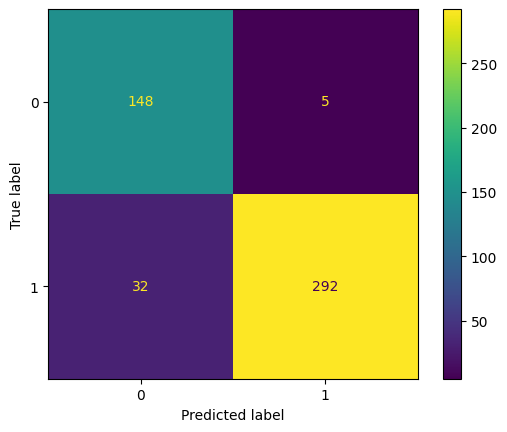

In [29]:
print(f"Scores for logistic regression model - OverSampled")
metric_scores(y_sm, logreg.predict(X_sm), data_type = "train")
metric_scores(y_test, logreg.predict(X_test_sca), data_type = "test")

with no oversampling in data

In [30]:
logreg1 = LogisticRegression(random_state = random_seed)
logreg1.fit(X_train_sca, y_train)

LogisticRegression(random_state=42)

Scores for logistic regression model - Basic
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9353991596638656
  precision_score = 0.9810699588477366
  recall_score = 0.9226006191950464
  f1_score = 0.9509373753490228
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.9266247379454927
  precision_score = 0.9832775919732442
  recall_score = 0.9074074074074074
  f1_score = 0.9438202247191012
  roc_auc_score = 0.937363834422658
  Classification Report
              precision    recall  f1-score   support

           0       0.83      0.97      0.89       153
           1       0.98      0.91      0.94       324

    accuracy                           0.93       477
   macro avg       0.91      0.94      0.92       477
weighted avg       0.93      0.93      0.93       477


  Confusion Matrix


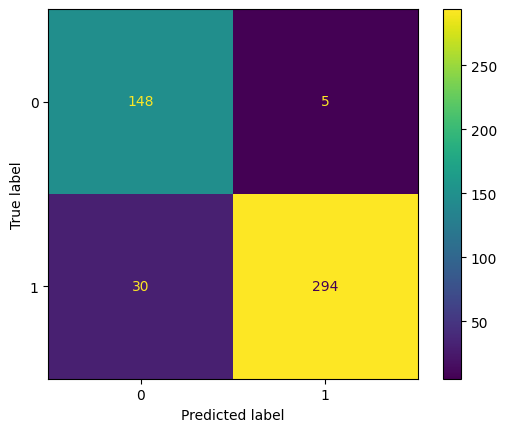

In [31]:
print(f"Scores for logistic regression model - Basic")
metric_scores(y_train, logreg1.predict(X_train_sca), data_type = "train")
metric_scores(y_test, logreg1.predict(X_test_sca), data_type = "test")

There is no much difference with respect to oversampling, this maybe due to the ratio between the majority to minority class being 67:33 (not so much dominating class), but we know logistic regression is impacted by imbalance in data. So, let's hypertune the model with oversampled data

Scores for logistic regression model (hyper parameters tuned)
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9454334365325078
  precision_score = 0.9721082854799016
  recall_score = 0.9171826625386997
  f1_score = 0.943847072879331
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.9203354297693921
  precision_score = 0.9798657718120806
  recall_score = 0.9012345679012346
  f1_score = 0.9389067524115756
  roc_auc_score = 0.9310094408133623
  Classification Report
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       153
           1       0.98      0.90      0.94       324

    accuracy                           0.92       477
   macro avg       0.90      0.93      0.91       477
weighted avg       0.93      0.92      0.92       477


  Confusion Matrix


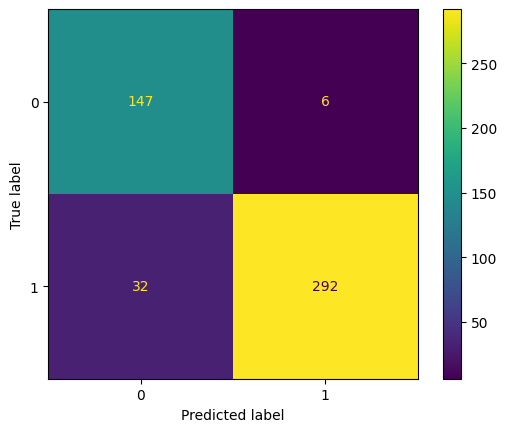

In [32]:
# c_values = np.arange(0.001, 1200, 10)

# param_grid = dict(C = c_values)

# logreg2 = grid_search_cv(LogisticRegression(random_state = random_seed, max_iter = 1000), param_grid, "f1", X_sm, y_sm, folds = 5)
logreg2 = LogisticRegression(random_state = random_seed, max_iter = 1000, C = 10.001)
logreg2.fit(X_sm, y_sm)

print(f"Scores for logistic regression model (hyper parameters tuned)")
metric_scores(y_sm, logreg2.predict(X_sm), data_type = "train")
metric_scores(y_test, logreg2.predict(X_test_sca), data_type = "test")

# best params = {'C': 10.001}

In [41]:
scores["LogisticRegression"] = {"no oversampling" : roc_auc_score(y_test, logreg1.predict(X_test_sca)),
                                    "oversampling" : roc_auc_score(y_test, logreg2.predict(X_test_sca))}

#### Decision Tree

with no oversampling

Fitting 5 folds for each of 10192 candidates, totalling 50960 fits
best params = {'ccp_alpha': 0.0001, 'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 40, 'min_samples_leaf': 8}

Scores for Decision Tree Classifier model (hyper parameters tuned)
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9380252100840336
  precision_score = 0.989983305509182
  recall_score = 0.9179566563467493
  f1_score = 0.9526104417670683
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.9245283018867925
  precision_score = 0.9768211920529801
  recall_score = 0.9104938271604939
  f1_score = 0.9424920127795527
  roc_auc_score = 0.932371096586783
  Classification Report
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       153
           1       0.98      0.91      0.94       324

    accuracy            

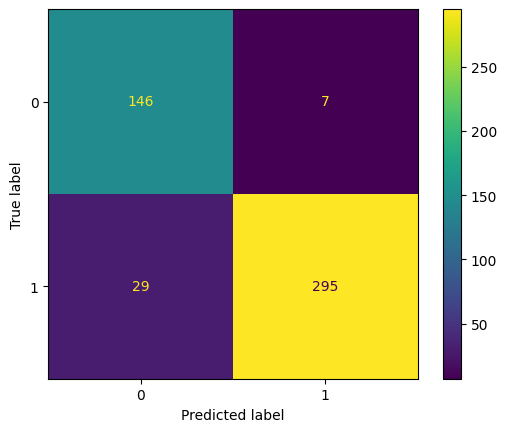

In [34]:
criterion = ["gini", "log_loss"]
max_depth = [_ for _ in range(5,70,5)]
max_features = ["sqrt", "log2"]
max_leaf_nodes = [_ for _ in range(10,80,10)]
min_samples_leaf = [_ for _ in range(2,21,3)]
ccp_alpha = [0.0001,0.001,0.1,1]

param_grid = dict(criterion = criterion, max_depth = max_depth, ccp_alpha = ccp_alpha, max_features = max_features, max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf)

decisionTreeClassifier1 = grid_search_cv(DecisionTreeClassifier(random_state = random_seed, splitter = "best", class_weight = "balanced"), param_grid, "f1", X_train, y_train, folds = 5)
decisionTreeClassifier1.fit(X_train, y_train)

print(f"\nScores for Decision Tree Classifier model (hyper parameters tuned)")
metric_scores(y_train, decisionTreeClassifier1.predict(X_train), data_type = "train")
metric_scores(y_test, decisionTreeClassifier1.predict(X_test), data_type = "test")

# best params = {'ccp_alpha': 0.0001, 'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 40, 'min_samples_leaf': 8}

with oversampling

In [35]:
smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X_train, y_train)
y_sm.value_counts()

churn
0    1292
1    1292
Name: count, dtype: int64

Fitting 5 folds for each of 10192 candidates, totalling 50960 fits


best params = {'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': 20, 'min_samples_leaf': 2}

Scores for Decision Tree Classifier model (hyper parameters tuned) - OverSampled
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9589783281733746
  precision_score = 0.978225806451613
  recall_score = 0.9388544891640866
  f1_score = 0.9581358609794628
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.9329140461215933
  precision_score = 0.974025974025974
  recall_score = 0.9259259259259259
  f1_score = 0.949367088607595
  roc_auc_score = 0.9368191721132897
  Classification Report
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       153
           1       0.97      0.93      0.95       324

    accuracy                           0.93       477
   macro avg       0.92      

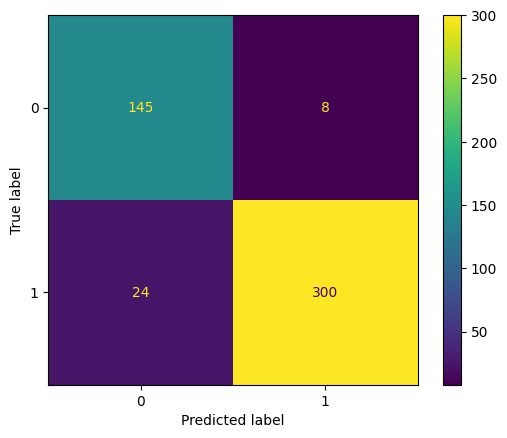

In [36]:
decisionTreeClassifier2 = grid_search_cv(DecisionTreeClassifier(random_state = random_seed, splitter = "best", class_weight = "balanced"), param_grid, "f1", X_sm, y_sm, folds = 5)
decisionTreeClassifier2.fit(X_sm, y_sm)

print(f"\nScores for Decision Tree Classifier model (hyper parameters tuned) - OverSampled")
metric_scores(y_sm, decisionTreeClassifier2.predict(X_sm), data_type = "train")
metric_scores(y_test, decisionTreeClassifier2.predict(X_test), data_type = "test")

# best params = {'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': 20, 'min_samples_leaf': 2}

In [42]:
scores["DecisonTreeClassifier"] = {"oversampling" : roc_auc_score(y_test, decisionTreeClassifier2.predict(X_test)),
                                    "no oversampling" : roc_auc_score(y_test, decisionTreeClassifier1.predict(X_test))}

In [43]:
pd.DataFrame(scores)

LogisticRegression  DecisonTreeClassifier
no oversampling            0.937364               0.932371
oversampling               0.931009               0.936819

#### RandomForestClassifier - Bagging

with no oversampling

In [44]:
grid = {
 "n_estimators" : [val for val in range (10,700, 80)],
 "max_depth" : [int(x) for x in np.linspace(5,45,5)],
 "min_samples_split" : [2, 5],
 "min_samples_leaf" : [2, 4,8], 
 "bootstrap" : [True, False],
 "ccp_alpha" : [.1, .01, .001,.0001]
}

rfc_model1 = grid_search_cv(RandomForestClassifier(random_state = random_seed, class_weight = "balanced", n_jobs = -1), grid, "f1", X_train, y_train, folds = 5)
rfc_model1.fit(X_train, y_train)

# best params = {'bootstrap': True, 'ccp_alpha': 0.001, 'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 170}

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits
best params = {'bootstrap': True, 'ccp_alpha': 0.001, 'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 170}


RandomForestClassifier(ccp_alpha=0.001, class_weight='balanced', max_depth=25,
                       min_samples_leaf=2, n_estimators=170, n_jobs=-1,
                       random_state=42)


Scores for RandomForest Classifier model (hyper parameters tuned) - no OverSampling
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9653361344537815
  precision_score = 0.9904
  recall_score = 0.958204334365325
  f1_score = 0.9740361919748229
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.9350104821802935
  precision_score = 0.9741100323624595
  recall_score = 0.9290123456790124
  f1_score = 0.9510268562401264
  roc_auc_score = 0.9383623819898329
  Classification Report
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       153
           1       0.97      0.93      0.95       324

    accuracy                           0.94       477
   macro avg       0.92      0.94      0.93       477
weighted avg       0.94      0.94      0.94       477


  Confusion Matrix


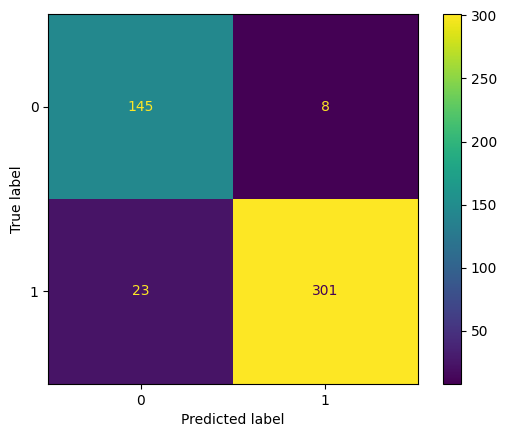

In [45]:
print(f"\nScores for RandomForest Classifier model (hyper parameters tuned) - no OverSampling")
metric_scores(y_train, rfc_model1.predict(X_train), data_type = "train")
metric_scores(y_test, rfc_model1.predict(X_test), data_type = "test")

with oversampling

In [46]:
rfc_model2 = RandomForestClassifier(random_state = random_seed, class_weight = "balanced_subsample", n_jobs = -1, bootstrap = True, ccp_alpha = 0.001, max_depth = 25, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 170)
rfc_model2.fit(X_sm, y_sm)

RandomForestClassifier(ccp_alpha=0.001, class_weight='balanced_subsample',
                       max_depth=25, min_samples_leaf=2, n_estimators=170,
                       n_jobs=-1, random_state=42)


Scores for RandomForest Classifier model (hyper parameters tuned) - OverSampling
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9705882352941176
  precision_score = 0.9864
  recall_score = 0.9543343653250774
  f1_score = 0.9701022816679781
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.9350104821802935
  precision_score = 0.980327868852459
  recall_score = 0.9228395061728395
  f1_score = 0.9507154213036566
  roc_auc_score = 0.9418119099491649
  Classification Report
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       153
           1       0.98      0.92      0.95       324

    accuracy                           0.94       477
   macro avg       0.92      0.94      0.93       477
weighted avg       0.94      0.94      0.94       477


  Confusion Matrix


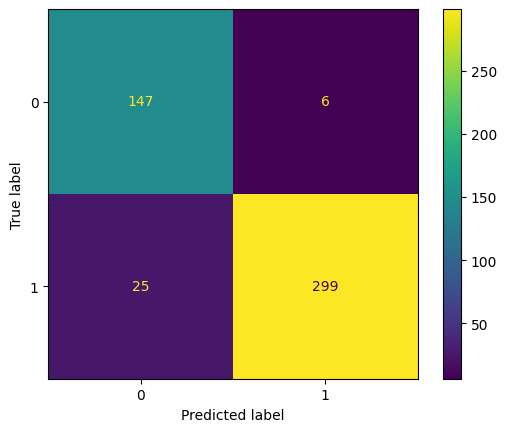

In [47]:
print(f"\nScores for RandomForest Classifier model (hyper parameters tuned) - OverSampling")
metric_scores(y_sm, rfc_model2.predict(X_sm), data_type = "train")
metric_scores(y_test, rfc_model2.predict(X_test), data_type = "test")

In [48]:
scores["RandomForestClassifier"] = {"oversampling" : roc_auc_score(y_test, rfc_model2.predict(X_test)),
                                    "no oversampling" : roc_auc_score(y_test, rfc_model1.predict(X_test))}

#### XGBoost - Boosting

with no oversampling

In [52]:
params = {
 "colsample_bytree": np.arange(0.5,1.0,1.0),
 "learning_rate": [0.1,0.3,0.5,0.7], 
 "max_depth": range(1,20,2), 
 "n_estimators": range(5,100,10), 
 "subsample": np.arange(0.5,1.0,1),
 "gamma":[0.1,0.3,0.5],
 "reg_lambda":[0.1,0.3,0.5]
}

xgb_model1 = grid_search_cv(XGBClassifier(random_state = random_seed), grid, "f1", X_train, y_train, folds = 5)
xgb_model1.fit(X_train, y_train)

# best params = {'bootstrap': True, 'ccp_alpha': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


/Users/praveenallam/anaconda3/envs/business_cases/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:31:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "ccp_alpha", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/praveenallam/anaconda3/envs/business_cases/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:31:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "ccp_alpha", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/praveenallam/anaconda3/envs/business_cases/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:31:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "ccp_alpha", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/praveenallam/anaconda3/envs/busin

best params = {'bootstrap': True, 'ccp_alpha': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}


XGBClassifier(base_score=None, booster=None, bootstrap=True, callbacks=None,
              ccp_alpha=0.1, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, min_samples_leaf=2, min_samples_split=2,
              missing=nan, monotone_constraints=None, multi_strategy=None, ...)


Scores for XGBoost Classifier model (hyper parameters tuned) - no OverSampling
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9642857142857143
  precision_score = 0.9788732394366197
  recall_score = 0.968266253869969
  f1_score = 0.9735408560311284
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.939203354297694
  precision_score = 0.9652996845425867
  recall_score = 0.9444444444444444
  f1_score = 0.9547581903276131
  roc_auc_score = 0.9362745098039217
  Classification Report
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       153
           1       0.97      0.94      0.95       324

    accuracy                           0.94       477
   macro avg       0.93      0.94      0.93       477
weighted avg       0.94      0.94      0.94       477


  Confusion Matrix


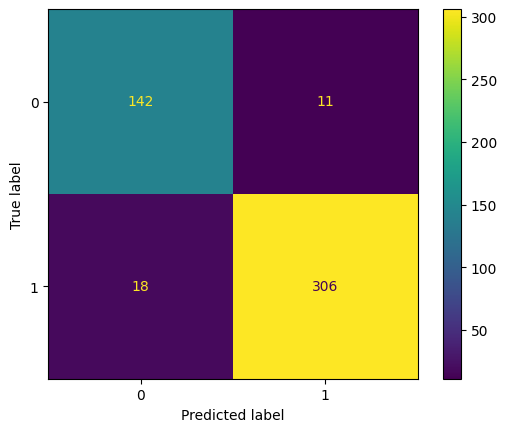

In [53]:
print(f"\nScores for XGBoost Classifier model (hyper parameters tuned) - no OverSampling")
metric_scores(y_train, xgb_model1.predict(X_train), data_type = "train")
metric_scores(y_test, xgb_model1.predict(X_test), data_type = "test")

with oversampling

In [54]:
xgb_model2 = XGBClassifier(bootstrap = True, ccp_alpha = 0.1, max_depth = 5, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 10)
xgb_model2.fit(X_sm, y_sm)

XGBClassifier(base_score=None, booster=None, bootstrap=True, callbacks=None,
              ccp_alpha=0.1, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, min_samples_leaf=2, min_samples_split=2,
              missing=nan, monotone_constraints=None, multi_strategy=None, ...)


Scores for XGBoost Classifier model (hyper parameters tuned) - OverSampling
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9663312693498453
  precision_score = 0.9847144006436042
  recall_score = 0.9473684210526315
  f1_score = 0.965680473372781
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.9350104821802935
  precision_score = 0.9771986970684039
  recall_score = 0.9259259259259259
  f1_score = 0.9508716323296355
  roc_auc_score = 0.940087145969499
  Classification Report
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       153
           1       0.98      0.93      0.95       324

    accuracy                           0.94       477
   macro avg       0.92      0.94      0.93       477
weighted avg       0.94      0.94      0.94       477


  Confusion Matrix


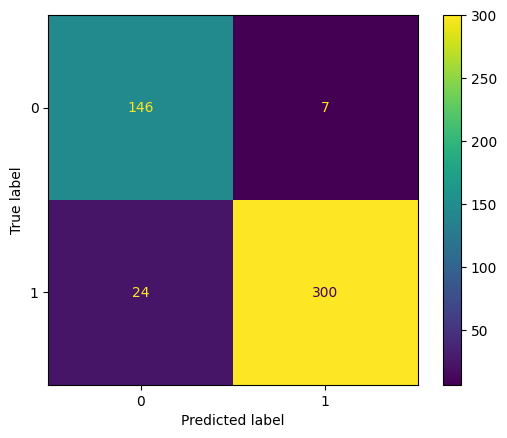

In [62]:
print(f"\nScores for XGBoost Classifier model (hyper parameters tuned) - OverSampling")
metric_scores(y_sm, xgb_model2.predict(X_sm), data_type = "train")
metric_scores(y_test, xgb_model2.predict(X_test), data_type = "test")

In [56]:
scores["XGBoostClassifier"] = {"oversampling" : roc_auc_score(y_test, xgb_model2.predict(X_test)),
                                    "no oversampling" : roc_auc_score(y_test, xgb_model1.predict(X_test))}

#### best model

In [63]:
scores = pd.DataFrame(scores.values(), index = scores.keys())
scores

no oversampling  oversampling
LogisticRegression             0.937364      0.931009
DecisonTreeClassifier          0.932371      0.936819
RandomForestClassifier         0.938362      0.941812
XGBoostClassifier              0.936275      0.940087

- RandomForestClassifier with oversampling gives the best result

feature importance

In [82]:
importances = rfc_model2.feature_importances_
feature_importance = pd.DataFrame(list(zip(list(X_train.columns), list(importances))), columns = ["feature", "importances"]).set_index("feature")
feature_importance

importances
feature                               
Income_mean                   0.011629
Income_last                   0.011068
Total Business Value_sum      0.038653
Total Business Value_min      0.001246
Total Business Value_max      0.014632
Total Business Value_mean     0.021480
Total Business Value_last     0.144943
City_last                     0.012258
Education_Level_last          0.004745
Joining Designation_last      0.016965
Age_max                       0.011412
Grade_min                     0.016587
Grade_max                     0.018221
Grade_mean                    0.019872
Grade_last                    0.016711
Quarterly Rating_max          0.021977
Gender_last                   0.005035
rating_change                 0.019472
income_change                 0.000068
days_worked                   0.051984
current_month                 0.541040

In [83]:
std = np.std([rfc_model2.feature_importances_ for tree in rfc_model2.estimators_], axis=0)

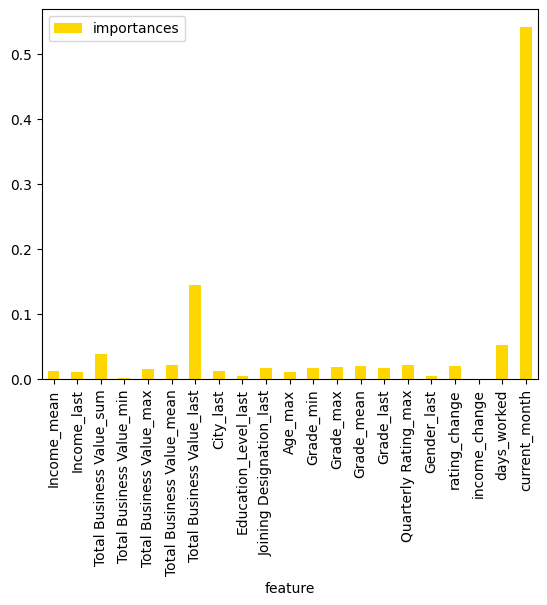

In [85]:
fig, ax = plt.subplots()
feature_importance.plot.bar(yerr=std, ax=ax, color = "gold")
plt.show()

- current month is the most important feature

Recommendations

1. The employees whose quarterly rating has increased are less likely to leave the organization
2. drivers whose monthly salary is not increased is likely to churn (so any incentive or rewards can be given)